In [1]:
!pip3 install -q -U tiktoken python-dotenv tabulate

In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import ast
# import altair as alt
import matplotlib.pyplot as plt
# import altair_catplot as altcat
# import seaborn as sns
# import wikipedia
# from wikidata.client import Client
# import wikipediaapi
import uuid
import re
import csv
# import jsonlines
import math
import random
import requests
import gzip
from typing import List, Any, Dict, Tuple
import tempfile
import copy
import string
import subprocess
import typing
import time
from datetime import datetime
# import tweepy
from collections import Counter, defaultdict
from scipy import stats
from tabulate import tabulate


%load_ext autoreload
%autoreload 2

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# from src.helpers import gpt
# from src.scripts import load_datasets
# from src.helpers import io
from src.scripts import run_fake_data_test
from src.helpers.visualisation import barplot_distribution, plot_confusion_matrix, tabulate_annotation_pair_summary, analyze_pair_annotations


In [77]:
prompt_fields_prev = [
    "multi_turn_relationship",
    "media_format",
    "topic",
    "function_purpose",
    "anthropomorphization",
    "restricted_flags",
]
response_fields_prev = [
    "answer_form",
    "self_disclosure",
    "topic_response",
    "media_format_response",
    "restricted_flags_response",
]

prompt_fields_new = [
    "multi_turn_relationship",
    "media_format",
    "topic",
    "interaction_features",
    # "function_purpose",
    "sensitive_use_flags",
]
response_fields_new = [
    "answer_form",
    "media_format",
    # "interaction_features",
    "restricted_flags_response",
]

## Run Analysis

In [65]:
# dset = run_fake_data_test.run_test_cedric()
dset = run_fake_data_test.run_automatic_analysis_v0()

Loading conversations from data/sample120.json
Loaded 120 conversations.
Added conversation IDs to 9 files
Split annotations into two folders:
  - data/labelstudio_outputs_split1/: Contains 115 annotations with unique conversation IDs
  - data/labelstudio_outputs_split2/: Contains 63 annotations with duplicate conversation IDs

gpt4o-json-full

prompt-multi_turn_relationship: 153 / 597 failed due to invalid annotations.
prompt-interaction_features: 1 / 597 failed due to invalid annotations.
turn-sensitive_use_flags: 30 / 597 failed due to invalid annotations.
turn-topic: 14 / 597 failed due to invalid annotations.
response-interaction_features: 0 / 597 failed due to invalid annotations.
prompt-media_format: 277 / 597 failed due to invalid annotations.
prompt-topic: 15 / 597 failed due to invalid annotations.
response-media_format: 327 / 597 failed due to invalid annotations.
response-answer_form: 1 / 597 failed due to invalid annotations.

gpt4o-free-full

prompt-multi_turn_relationshi

In [66]:
# dset.data[0].to_dict()

In [67]:
# dset.data[0].conversation[0].to_dict()

In [70]:
def run_interrater_comparison(
    dataset, 
    task_name,
    annotation_source_1,
    annotation_source_2,
):
    info_to_plot1 = dset.get_annotation_distribution(name=task_name, level="message", annotation_source=annotation_source_1)
    info_to_plot2 = dset.get_annotation_distribution(name=task_name, level="message", annotation_source=annotation_source_2)
    info_to_plot1b = dset.get_annotation_distribution(name=task_name, level="message", annotation_source=annotation_source_1, annotation_as_list_type=True)
    info_to_plot2b = dset.get_annotation_distribution(name=task_name, level="message", annotation_source=annotation_source_2, annotation_as_list_type=True)

    outdir = f"data/annotation_analysis_v0/{annotation_source_1}--{annotation_source_2}/{task_name}"
    os.makedirs(outdir, exist_ok=True)
    fig = barplot_distribution(
        {"Split1": info_to_plot1, "Split2": info_to_plot2}, normalize=True, 
        xlabel=task_name, ylabel="Proportion", title="",
        output_path=f"{outdir}/barchart.png", order="descending")
    
    fig_b = barplot_distribution(
        {"Split1": info_to_plot1b, "Split2": info_to_plot2b}, normalize=True, 
        xlabel=task_name, ylabel="Proportion", title="",
        output_path=f"{outdir}/multilabel_barchart.png", order="descending")

    info_to_plot_cm, agreement_metrics, paired_values = dataset.get_joint_distribution(
        annotations1=(task_name, annotation_source_1), 
        annotations2=(task_name, annotation_source_2), 
        level="message",
        compute_disagreement=True,
        verbose=True
    )
    # print(info_to_plot_cm)

    fig2 = plot_confusion_matrix(
        info_to_plot_cm, normalize=True, xlabel="", ylabel="", title="Confusion Matrix",
        output_path=f"{outdir}/confusion_matrix.png")

    # print(paired_values[0:3])
    df = analyze_pair_annotations(paired_values)
    df.to_csv(f"{outdir}/pair_frequencies.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

    print()
    print(f"-----------------{task_name}-----------------")
    print(agreement_metrics)
    print(tabulate_annotation_pair_summary(df, 20))
    print(len(df))
    print()
    return paired_values


In [76]:
dset.data[0].conversation[0].to_dict()

{'turn': 0,
 'role': 'user',
 'content': 'как часто люди посещают интерактивные парки?',
 'timestamp': None,
 'metadata': {'split1-media_format': {'value': ['Natural language'],
   'target_id': 'wildchat_3131223896373a804d9d893ca41f464b-0',
   'annotator': 'ahmet'},
  'split1-topic': {'value': ['Culture'],
   'target_id': 'wildchat_3131223896373a804d9d893ca41f464b-0',
   'annotator': 'ahmet'},
  'split1-function_purpose': {'value': ['Information retrieval: general info from web'],
   'target_id': 'wildchat_3131223896373a804d9d893ca41f464b-0',
   'annotator': 'ahmet'},
  'split1-multi_turn_relationship': {'value': ['First request'],
   'target_id': 'wildchat_3131223896373a804d9d893ca41f464b-0',
   'annotator': 'ahmet'},
  'split2-media_format': {'value': ['Natural language'],
   'target_id': 'wildchat_3131223896373a804d9d893ca41f464b-0',
   'annotator': 'tea-shaped'},
  'split2-topic': {'value': ['Travel & Tourism',
    'Entertainment, Hobbies & Leisure'],
   'target_id': 'wildchat_3131

Found 444 items with `gpt4o_json_full-multi_turn_relationship`, and 423 with `gpt4o_free_full-multi_turn_relationship`.
Generated 390 label-level pairs (at level=message) out of 1195 total items.

-----------------multi_turn_relationship-----------------
{'label_agreement_rate': 0.941025641025641, 'cohens_kappa': 0.9085710791058924}
+-------------------------------+----------------------------------------------+---------+------------------+------------+
| val1                          | val2                                         |   count |   percent_of_all | matching   |
+===============================+==============================================+=========+==================+============+
| ['Ext dee or bui on pri tas'] | ['Ext dee or bui on pri tas']                |     168 |            43.08 | T          |
+-------------------------------+----------------------------------------------+---------+------------------+------------+
| ['First request']             | ['First request'

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 353 items with `gpt4o_json_full-media_format`, and 597 with `gpt4o_free_full-media_format`.
Generated 353 label-level pairs (at level=message) out of 1195 total items.

-----------------media_format-----------------
{'label_agreement_rate': 0.5977337110481586, 'cohens_kappa': 0.4676847269715184}
+------------------------------------------+--------------------------------------+---------+------------------+------------+
| val1                                     | val2                                 |   count |   percent_of_all | matching   |
+==========================================+======================================+=========+==================+============+
| ['Natural language']                     | ['Natural language']                 |     132 |            37.39 | T          |
+------------------------------------------+--------------------------------------+---------+------------------+------------+
| ['Code', 'Natural language']             | ['Code', 'Natural lang

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')
/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 597 items with `gpt4o_json_full-topic`, and 597 with `gpt4o_free_full-topic`.
Generated 597 label-level pairs (at level=message) out of 1195 total items.

-----------------topic-----------------
{'label_agreement_rate': 0.38358458961474035, 'cohens_kappa': 0.36720768466379594}
+---------------------------------------------------------------+---------------------------------------------------------------+---------+------------------+------------+
| val1                                                          | val2                                                          |   count |   percent_of_all | matching   |
+===============================================================+===============================================================+=========+==================+============+
| ['Content generation (code)']                                 | ['Content generation (code)']                                 |      31 |             5.19 | T          |
+---------------------------

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 597 items with `gpt4o_json_full-interaction_features`, and 597 with `gpt4o_free_full-interaction_features`.
Generated 597 label-level pairs (at level=message) out of 1195 total items.

-----------------interaction_features-----------------
{'label_agreement_rate': 0.6214405360134003, 'cohens_kappa': 0.31508198385704855}
+-------------------------------------------+---------------------------------------+---------+------------------+------------+
| val1                                      | val2                                  |   count |   percent_of_all | matching   |
+===========================================+=======================================+=========+==================+============+
| ['None']                                  | ['None']                              |     278 |            46.57 | T          |
+-------------------------------------------+---------------------------------------+---------+------------------+------------+
| []                            

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')
/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 567 items with `gpt4o_json_full-sensitive_use_flags`, and 563 with `gpt4o_free_full-sensitive_use_flags`.
Generated 558 label-level pairs (at level=message) out of 1195 total items.

-----------------sensitive_use_flags-----------------
{'label_agreement_rate': 0.6989247311827957, 'cohens_kappa': 0.201907032181168}
+-------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------+------------------+------------+
| val1                                                                          | val2                                                                                |   count |   percent_of_all | matching   |
+===============================================================================+=====================================================================================+=========+==================+============+
| ['None']                                     

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 596 items with `gpt4o_json_full-answer_form`, and 597 with `gpt4o_free_full-answer_form`.
Generated 596 label-level pairs (at level=message) out of 1195 total items.

-----------------answer_form-----------------
{'label_agreement_rate': 0.9211409395973155, 'cohens_kappa': 0.6663569880178184}
+-----------------------------------------------+-----------------------------------------------+---------+------------------+------------+
| val1                                          | val2                                          |   count |   percent_of_all | matching   |
+===============================================+===============================================+=========+==================+============+
| ['Dir Ans / Ope Gen']                         | ['Dir Ans / Ope Gen']                         |     501 |            84.06 | T          |
+-----------------------------------------------+-----------------------------------------------+---------+------------------+------------+


/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Found 353 items with `gpt4o_json_full-media_format`, and 597 with `gpt4o_free_full-media_format`.
Generated 353 label-level pairs (at level=message) out of 1195 total items.

-----------------media_format-----------------
{'label_agreement_rate': 0.5977337110481586, 'cohens_kappa': 0.4676847269715184}
+------------------------------------------+--------------------------------------+---------+------------------+------------+
| val1                                     | val2                                 |   count |   percent_of_all | matching   |
+==========================================+======================================+=========+==================+============+
| ['Natural language']                     | ['Natural language']                 |     132 |            37.39 | T          |
+------------------------------------------+--------------------------------------+---------+------------------+------------+
| ['Code', 'Natural language']             | ['Code', 'Natural lang

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Found 0 items with `gpt4o_json_full-restricted_flags_response`, and 0 with `gpt4o_free_full-restricted_flags_response`.
Generated 0 label-level pairs (at level=message) out of 1195 total items.


ValueError: zero-size array to reduction operation fmin which has no identity

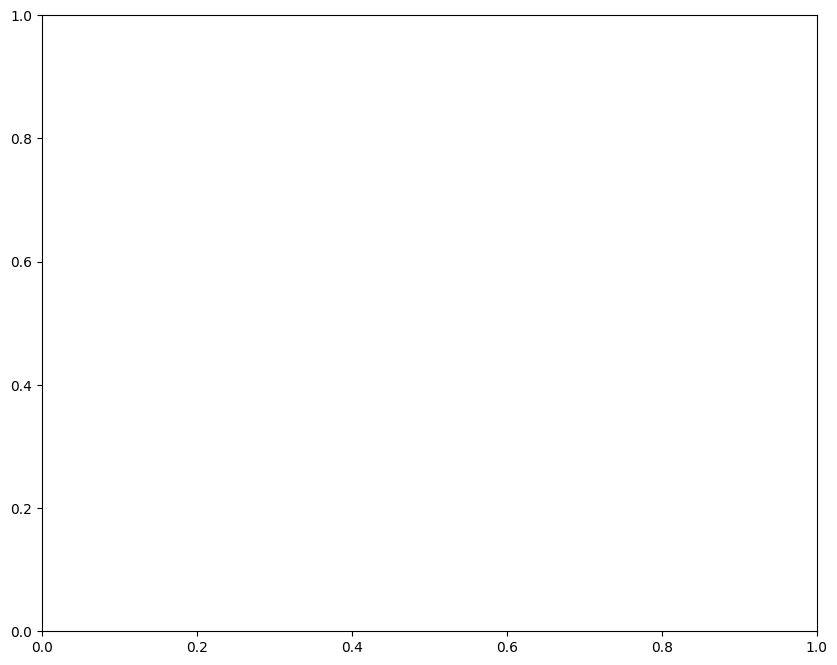

In [78]:
task_annotations = {}
for feature in prompt_fields_new:
    task_annotations[feature] = run_interrater_comparison(dset, feature, "gpt4o_json_full", "gpt4o_free_full")
    # break
for feature in response_fields_new:
    task_annotations[feature] = run_interrater_comparison(dset, feature, "gpt4o_json_full", "gpt4o_free_full")
    # break

In [60]:
task_annotations = {}
for feature in prompt_fields_prev:
    task_annotations[feature] = run_interrater_comparison(dset, feature, "split1", "split2")
    # break
for feature in response_fields_prev:
    task_annotations[feature] = run_interrater_comparison(dset, feature, "split1", "split2")
    # break

Found 218 items with `split1-multi_turn_relationship`, and 107 with `split2-multi_turn_relationship`.
Generated 104 label-level pairs (at level=message) out of 1195 total items.

-----------------multi_turn_relationship-----------------
{'label_agreement_rate': 0.8365384615384616, 'cohens_kappa': 0.7250388802488337}
+----------------------------+----------------------------+---------+------------------+------------+
| val1                       | val2                       |   count |   percent_of_all | matching   |
+============================+============================+=========+==================+============+
| ['First request']          | ['First request']          |      61 |            58.65 | T          |
+----------------------------+----------------------------+---------+------------------+------------+
| ['Related request']        | ['Related request']        |      10 |             9.62 | T          |
+----------------------------+----------------------------+---------+-

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 220 items with `split1-media_format`, and 106 with `split2-media_format`.
Generated 105 label-level pairs (at level=message) out of 1195 total items.

-----------------media_format-----------------
{'label_agreement_rate': 0.8380952380952381, 'cohens_kappa': 0.4690660321237359}
+--------------------------------------------+---------------------------------+---------+------------------+------------+
| val1                                       | val2                            |   count |   percent_of_all | matching   |
+============================================+=================================+=========+==================+============+
| ['Natural language']                       | ['Natural language']            |      81 |            77.14 | T          |
+--------------------------------------------+---------------------------------+---------+------------------+------------+
| ['For enu', 'Nat lan']                     | ['Natural language']            |       9 |          

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 220 items with `split1-topic`, and 108 with `split2-topic`.
Generated 106 label-level pairs (at level=message) out of 1195 total items.

-----------------topic-----------------
{'label_agreement_rate': 0.3113207547169811, 'cohens_kappa': 0.2645884812773237}
+---------------------------------------+---------------------------------------------+---------+------------------+------------+
| val1                                  | val2                                        |   count |   percent_of_all | matching   |
+=======================================+=============================================+=========+==================+============+
| ['Tec Sof & Com']                     | ['Tec Sof & Com']                           |      10 |             9.43 | T          |
+---------------------------------------+---------------------------------------------+---------+------------------+------------+
| ['Literature & Writing']              | ['Literature & Writing']                    

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')
/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 218 items with `split1-function_purpose`, and 106 with `split2-function_purpose`.
Generated 105 label-level pairs (at level=message) out of 1195 total items.

-----------------function_purpose-----------------
{'label_agreement_rate': 0.2857142857142857, 'cohens_kappa': 0.2577057215571684}
+-------------------------------------+--------------------------------------------------------+---------+------------------+------------+
| val1                                | val2                                                   |   count |   percent_of_all | matching   |
+=====================================+========================================================+=========+==================+============+
| ['IR: web']                         | ['IR: web']                                            |       6 |             5.71 | T          |
+-------------------------------------+--------------------------------------------------------+---------+------------------+------------+
| ['Gen:

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 32 items with `split1-restricted_flags`, and 19 with `split2-restricted_flags`.
Generated 3 label-level pairs (at level=message) out of 1195 total items.

-----------------restricted_flags-----------------
{'label_agreement_rate': 0.6666666666666666, 'cohens_kappa': 0.5}
+-------------------------+----------------------------+---------+------------------+------------+
| val1                    | val2                       |   count |   percent_of_all | matching   |
+=========================+============================+=========+==================+============+
| ['Sex exp con fic per'] | ['Sex exp con fic per']    |       1 |            33.33 | T          |
+-------------------------+----------------------------+---------+------------------+------------+
| ['Other']               | ['Sex exp con Req of CSA'] |       1 |            33.33 | F          |
+-------------------------+----------------------------+---------+------------------+------------+
| ['Other']               | [

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 201 items with `split1-topic_response`, and 107 with `split2-topic_response`.
Generated 95 label-level pairs (at level=message) out of 1195 total items.

-----------------topic_response-----------------
{'label_agreement_rate': 0.3263157894736842, 'cohens_kappa': 0.28284972870960134}
+---------------------------------------+----------------------------------------------+---------+------------------+------------+
| val1                                  | val2                                         |   count |   percent_of_all | matching   |
+=======================================+==============================================+=========+==================+============+
| ['Literature & Writing']              | ['Literature & Writing']                     |       7 |             7.37 | T          |
+---------------------------------------+----------------------------------------------+---------+------------------+------------+
| ['Eng & Inf', 'Tec Sof & Com']        | ['Tec Sof & 

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 216 items with `split1-media_format_response`, and 106 with `split2-media_format_response`.
Generated 102 label-level pairs (at level=message) out of 1195 total items.

-----------------media_format_response-----------------
{'label_agreement_rate': 0.6078431372549019, 'cohens_kappa': 0.41938238223993163}
+---------------------------------------------------+--------------------------------------+---------+------------------+------------+
| val1                                              | val2                                 |   count |   percent_of_all | matching   |
+===================================================+======================================+=========+==================+============+
| ['Natural language']                              | ['Natural language']                 |      38 |            37.25 | T          |
+---------------------------------------------------+--------------------------------------+---------+------------------+------------+
| ['For enu'

/Users/shayne/Documents/research/naturalistic-data/naturalistic-ai/src/helpers/visualisation.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(output_path, bbox_inches='tight')


Found 29 items with `split1-restricted_flags_response`, and 15 with `split2-restricted_flags_response`.
Generated 2 label-level pairs (at level=message) out of 1195 total items.

-----------------restricted_flags_response-----------------
{'label_agreement_rate': 0.5, 'cohens_kappa': 0.0}
+-------------------------+-------------------------+---------+------------------+------------+
| val1                    | val2                    |   count |   percent_of_all | matching   |
+=========================+=========================+=========+==================+============+
| ['Sex exp con fic per'] | ['Sex exp con fic per'] |       1 |               50 | T          |
+-------------------------+-------------------------+---------+------------------+------------+
| ['Other']               | ['Sex exp con fic per'] |       1 |               50 | F          |
+-------------------------+-------------------------+---------+------------------+------------+
2



Loading conversations from data/sample120.json
Loaded 120 conversations.
Added conversation IDs to 9 files
Split annotations into two folders:
  - data/labelstudio_outputs_split1/: Contains 115 annotations with unique conversation IDs
  - data/labelstudio_outputs_split2/: Contains 63 annotations with duplicate conversation IDs

gpt4o-json-full

prompt-multi_turn_relationship: 153 / 597 failed due to invalid annotations.
prompt-interaction_features: 1 / 597 failed due to invalid annotations.
turn-sensitive_use_flags: 30 / 597 failed due to invalid annotations.
turn-topic: 14 / 597 failed due to invalid annotations.
response-interaction_features: 0 / 597 failed due to invalid annotations.
prompt-media_format: 277 / 597 failed due to invalid annotations.
prompt-topic: 15 / 597 failed due to invalid annotations.
response-media_format: 327 / 597 failed due to invalid annotations.
response-answer_form: 1 / 597 failed due to invalid annotations.

gpt4o-free-full

prompt-multi_turn_relationshi

In [169]:

# non_matching_ids = [x[0] for x in task_annotations["media_format"] if x[1] != x[2]]
# dset.id_lookup(non_matching_ids, level="message")